# Time Series Model Validation Demo

## Import Libraries 

In [5]:
# System libraries
import glob

# ML libraries
import pickle 
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Time Series Models

In [6]:
with open('../models/time_series/fred_loan_rates_model_1.pkl', 'rb') as f:
    model_1 = pickle.load(f)
print(model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.284
Method:                 Least Squares   F-statistic:                              198.8
Date:                Tue, 09 May 2023   Prob (F-statistic):                    3.22e-38
Time:                        13:36:27   Log-Likelihood:                         -57.220
No. Observations:                 498   AIC:                                      116.4
Df Residuals:                     497   BIC:                                      120.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
with open('../models/time_series/fred_loan_rates_model_2.pkl', 'rb') as f:
    model_2 = pickle.load(f)
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     198.3
Date:                Tue, 09 May 2023   Prob (F-statistic):           3.99e-38
Time:                        13:36:27   Log-Likelihood:                -57.120
No. Observations:                 498   AIC:                             118.2
Df Residuals:                     496   BIC:                             126.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.012     -0.448      0.6

In [8]:
with open('../models/time_series/fred_loan_rates_model_3.pkl', 'rb') as f:
    model_3 = pickle.load(f)
print(model_3.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              558.1
Date:                Tue, 09 May 2023   Prob (F-statistic):                    2.80e-83
Time:                        13:36:27   Log-Likelihood:                          46.439
No. Observations:                 498   AIC:                                     -90.88
Df Residuals:                     497   BIC:                                     -86.67
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
with open('../models/time_series/fred_loan_rates_model_4.pkl', 'rb') as f:
    model_4 = pickle.load(f)
print(model_4.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              407.0
Date:                Tue, 09 May 2023   Prob (F-statistic):                   2.45e-105
Time:                        13:36:27   Log-Likelihood:                          100.84
No. Observations:                 498   AIC:                                     -197.7
Df Residuals:                     496   BIC:                                     -189.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [10]:
with open('../models/time_series/fred_loan_rates_model_5.pkl', 'rb') as f:
    model_5 = pickle.load(f)
print(model_5.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              271.0
Date:                Tue, 09 May 2023   Prob (F-statistic):                   4.91e-104
Time:                        13:36:27   Log-Likelihood:                          100.97
No. Observations:                 498   AIC:                                     -195.9
Df Residuals:                     495   BIC:                                     -183.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Load Training Datasets

In [11]:
# Extract the endogenous (target) variable from the model fit
train_df = pd.Series(model_1.model.endog, index=model_1.model.data.row_labels)
train_df = train_df.to_frame()
target_var_name = model_1.model.endog_names
train_df.columns = [target_var_name]

# Extract the exogenous (explanatory) variables from the model fit
exog_df = pd.DataFrame(model_1.model.exog, index=model_1.model.data.row_labels, columns=model_1.model.exog_names)

# Concatenate the endogenous (target) and exogenous (explanatory) variables
train_df = pd.concat([train_df, exog_df], axis=1)
train_df.head()

,MORTGAGE30US,FEDFUNDS
DATE,,
1971-05-01,0.17,0.47
1971-06-01,0.08,0.28
1971-07-01,0.15,0.40
1971-08-01,0.00,0.26
1971-09-01,-0.02,-0.02


In [12]:
train_df.tail()

,MORTGAGE30US,FEDFUNDS
DATE,,
2012-06-01,-0.09,0.00
2012-07-01,-0.17,0.00
2012-08-01,0.10,-0.03
2012-09-01,-0.19,0.01
2012-10-01,0.01,0.02


## Load Test Datasets

Load raw test dataset.

In [35]:
file = '../datasets/time_series/fred_loan_rates_test_1.csv'
raw_test_df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')
display(raw_test_df)

,MORTGAGE30US,UNRATE,GS10,FEDFUNDS
DATE,,,,
2012-11-01,3.32,7.7,1.65,0.16
2012-12-01,3.35,7.9,1.72,0.16
2013-01-01,3.53,8.0,1.91,0.14
2013-02-01,3.51,7.7,1.98,0.15
2013-03-01,3.57,7.5,1.96,0.14
...,...,...,...,...
2022-11-01,6.58,3.6,3.89,3.78
2022-12-01,6.42,3.5,3.62,4.10
2023-01-01,6.13,3.4,3.53,4.33


Transform raw test dataset using same transformation used in the train dataset. 

In [38]:
transform_func = 'diff'
if transform_func == 'diff':
    test_df = raw_test_df.diff().dropna()

## Load Predictions

In [27]:
def get_model_prediction(model_fits_dict, df_test):
    # Extract the training data from the first model fit
    first_model_fit = list(model_fits_dict.values())[0]
    train_data = pd.Series(first_model_fit.model.endog, index=first_model_fit.model.data.row_labels)
    train_data = train_data.to_frame()
    target_var_name = first_model_fit.model.endog_names
    train_data.columns = [f'{target_var_name}_train']

    # Initialize an empty DataFrame to store the predictions
    prediction_df = pd.DataFrame(index=df_test.index)
    prediction_df[f'{target_var_name}_test'] = np.nan

    # Concatenate the train_data and prediction_df
    combined_df = pd.concat([train_data, prediction_df], axis=0)

    # Loop through each model fit
    for model_name, model_fit in model_fits_dict.items():
        # Prepare the test dataset
        exog_names = model_fit.model.exog_names
        X_test = df_test.copy()

        # Add the constant if it's missing
        if 'const' in exog_names and 'const' not in X_test.columns:
            X_test['const'] = 1.0

        # Select the necessary columns
        X_test = X_test[exog_names]

        # Generate the predictions
        predictions = model_fit.predict(X_test)

        # Add the predictions to the DataFrame
        combined_df[model_name] = np.nan
        combined_df[model_name].iloc[len(train_data):] = predictions

    # Add the test data to the '<target_variable>_test' column
    combined_df[f'{target_var_name}_test'].iloc[len(train_data):] = df_test[target_var_name]

    return combined_df



In [39]:
# Replace with your list of model fits
model_fits = {
    'model_1': model_1,
    'model_3': model_3
}  
prediction_df = get_model_prediction(model_fits, test_df)
display(prediction_df)

,MORTGAGE30US_train,MORTGAGE30US_test,model_1,model_3
DATE,,,,
1971-05-01,0.17,NaN,NaN,NaN
1971-06-01,0.08,NaN,NaN,NaN
1971-07-01,0.15,NaN,NaN,NaN
1971-08-01,0.00,NaN,NaN,NaN
1971-09-01,-0.02,NaN,NaN,NaN
...,...,...,...,...
2022-11-01,NaN,-0.50,0.203037,-0.066856
2022-12-01,NaN,-0.16,0.092817,-0.200567
2023-01-01,NaN,-0.29,0.066712,-0.066856


In [52]:
def plot_predictions(prediction_df, subplot=True):
    n_models = prediction_df.shape[1] - 2
    
    if subplot:
        fig, axes = plt.subplots(n_models, 1, figsize=(12, 6 * n_models), sharex=True)
        
        for i in range(n_models):
            axes[i].plot(prediction_df.index, prediction_df.iloc[:, 0], label=prediction_df.columns[0], color='grey')
            axes[i].plot(prediction_df.index, prediction_df.iloc[:, 1], label=prediction_df.columns[1], color='lightgrey')
            axes[i].plot(prediction_df.index, prediction_df.iloc[:, i + 2], label=prediction_df.columns[i + 2], linestyle='-')
            axes[i].set_ylabel('Target Variable')
            axes[i].set_title(f'Test Data vs. {prediction_df.columns[i + 2]}')
            axes[i].legend()
            axes[i].grid(True)
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()
        
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(prediction_df.index, prediction_df.iloc[:, 0], label=prediction_df.columns[0], color='grey')
        plt.plot(prediction_df.index, prediction_df.iloc[:, 1], label=prediction_df.columns[1], color='lightgrey')
        
        for i in range(2, prediction_df.shape[1]):
            plt.plot(prediction_df.index, prediction_df.iloc[:, i], label=prediction_df.columns[i], linestyle='-')
        
        plt.xlabel('Date')
        plt.ylabel('Target Variable')
        plt.title('Test Data vs. Model Forecasts')
        plt.legend()
        plt.grid(True)
        plt.show()

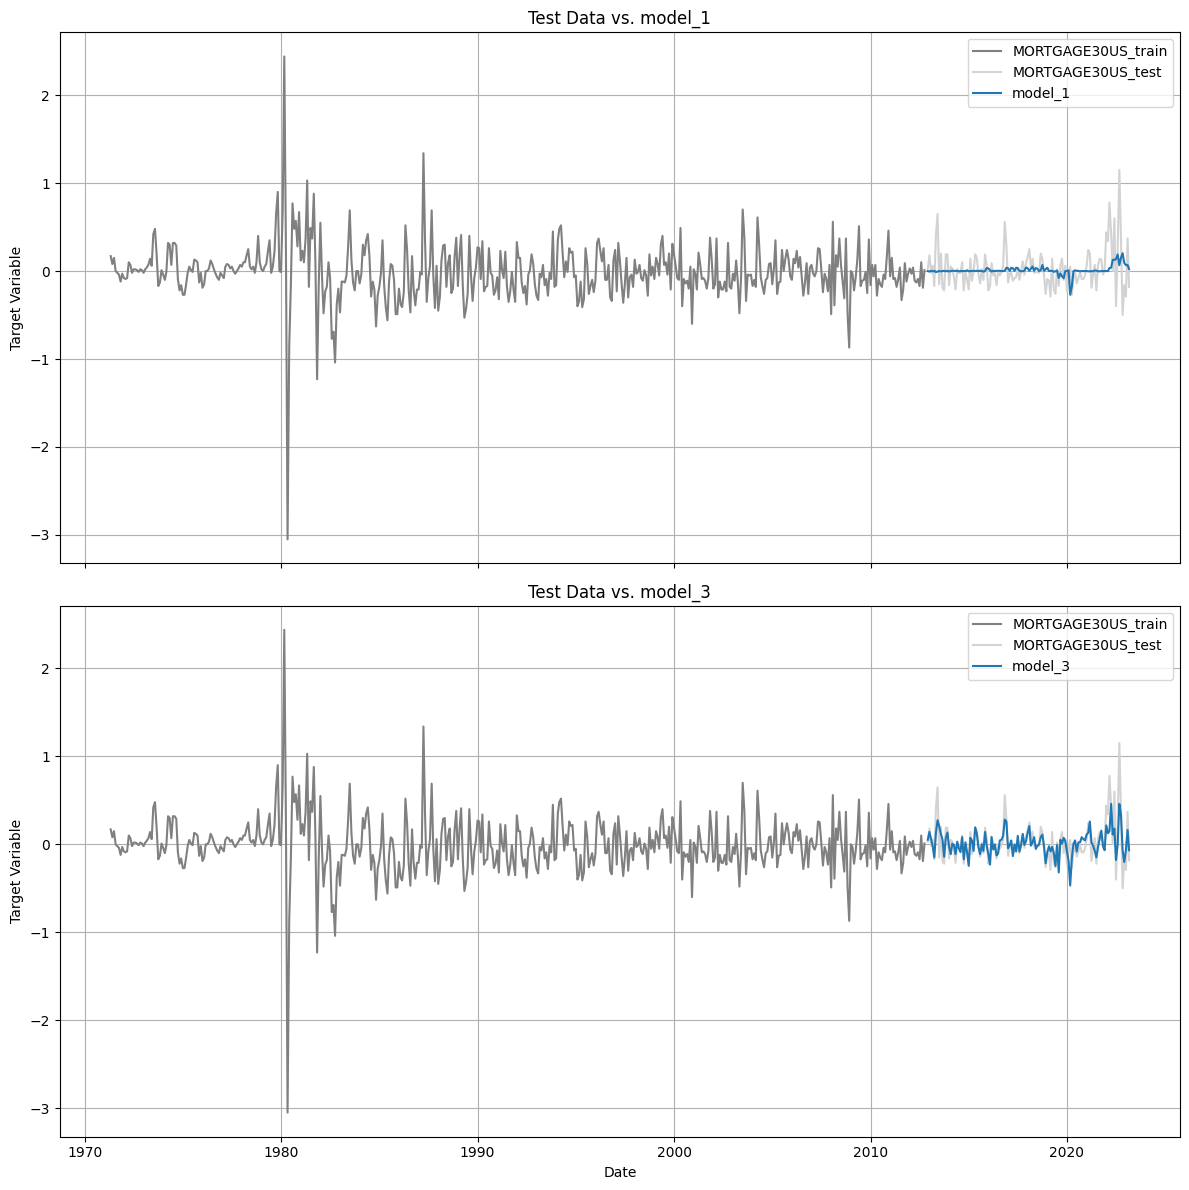

In [55]:
plot_predictions(prediction_df, subplot=True)